# LoveDA Dataset Preprocessing

In [1]:
# Download code - FOR REFERENCE ONLY (not executed)
# Dataset was manually downloaded from: https://zenodo.org/records/5706578

"""
import requests
import zipfile
import os
from tqdm import tqdm

def download_loveda(save_dir="./LoveDA"):
    urls = {
        "Train": "https://zenodo.org/records/5706578/files/Train.zip?download=1",
        "Val": "https://zenodo.org/records/5706578/files/Val.zip?download=1",
        "Test": "https://zenodo.org/records/5706578/files/Test.zip?download=1"
    }
    
    os.makedirs(save_dir, exist_ok=True)
    
    for name, url in urls.items():
        print(f"Downloading {name}...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        zip_path = os.path.join(save_dir, f"{name}.zip")
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        print(f"Extracting {name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(save_dir)
        os.remove(zip_path)
    
    print("Download complete!")

# download_loveda("./LoveDA")
"""
print("Download code provided for reference only.")
print("Dataset manually downloaded from: https://zenodo.org/records/5706578")

Download code provided for reference only.
Dataset manually downloaded from: https://zenodo.org/records/5706578


## Import Libraries and Configuration

In [2]:
import os
import numpy as np
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import json
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Configuration
# Input path 
SOURCE_DIR = r"F:\Train\Train\Rural"  
# Output path
OUTPUT_DIR = r"F:\Train\Train\LoveDA_Processed" 

# Image parameters
ORIGINAL_SIZE = 1024  # LoveDA original size
TARGET_SIZE = 512     # Attention U-Net input size
# Selection criteria
FOREST_LABEL = 6      # Forest class label in LoveDA
MIN_FOREST_RATIO = 0.30  # Minimum forest coverage (30%)
MAX_FOREST_RATIO = 0.70  # Maximum forest coverage (70%)
NUM_IMAGES = 100      # Total images to select

# Dataset split ratios (7:2:1)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Random seed for reproducibility
RANDOM_SEED = 42

image_dir = os.path.join(SOURCE_DIR, "images_png")
mask_dir = os.path.join(SOURCE_DIR, "masks_png")

## Scan and Filter Images by Forest Coverage

In [5]:
def calculate_forest_ratio(mask_path, forest_label=6):
    """
    Calculate the ratio of forest pixels in a mask image.
    """
    mask = np.array(Image.open(mask_path))
    forest_pixels = np.sum(mask == forest_label)
    total_pixels = mask.size
    return forest_pixels / total_pixels

In [6]:
qualified_images = []  # Images meeting criteria
all_images = []        # All images with their ratios

mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
total = len(mask_files)

for i, mask_name in enumerate(mask_files):
    mask_path = os.path.join(mask_dir, mask_name)
    forest_ratio = calculate_forest_ratio(mask_path, FOREST_LABEL)
    
    all_images.append((mask_name, forest_ratio))
    
    # Check if within desired range
    if MIN_FOREST_RATIO <= forest_ratio <= MAX_FOREST_RATIO:
        qualified_images.append((mask_name, forest_ratio))
    
    # Progress indicator
    if (i + 1) % 100 == 0 or i == total - 1:
        print(f"  Processed: {i + 1}/{total}, Qualified: {len(qualified_images)}")

print(f"  Total images scanned: {total}")
print(f"  Images with {MIN_FOREST_RATIO*100:.0f}%-{MAX_FOREST_RATIO*100:.0f}% forest: {len(qualified_images)}")

  Processed: 100/1366, Qualified: 19
  Processed: 200/1366, Qualified: 38
  Processed: 300/1366, Qualified: 63
  Processed: 400/1366, Qualified: 87
  Processed: 500/1366, Qualified: 105
  Processed: 600/1366, Qualified: 124
  Processed: 700/1366, Qualified: 150
  Processed: 800/1366, Qualified: 169
  Processed: 900/1366, Qualified: 186
  Processed: 1000/1366, Qualified: 206
  Processed: 1100/1366, Qualified: 217
  Processed: 1200/1366, Qualified: 239
  Processed: 1300/1366, Qualified: 255
  Processed: 1366/1366, Qualified: 269
  Total images scanned: 1366
  Images with 30%-70% forest: 269


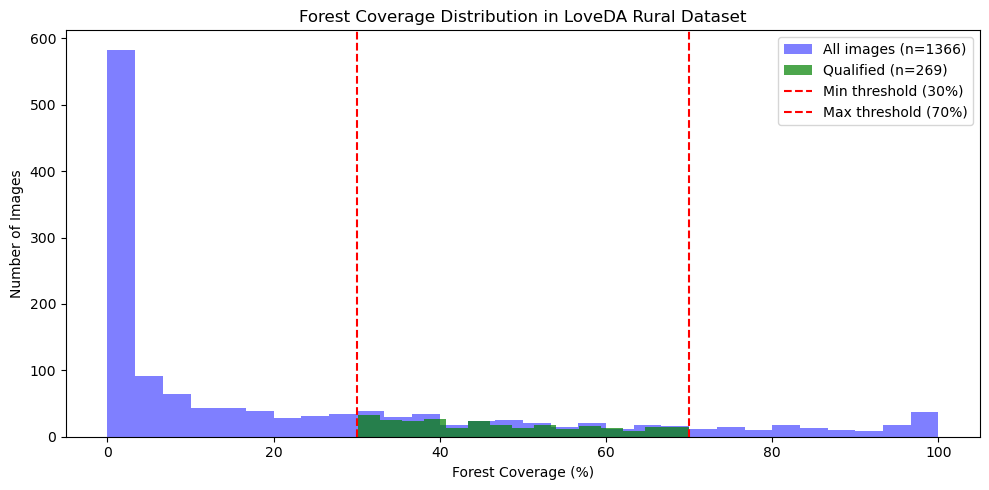

  Mean forest coverage: 46.7%
  Std: 11.5%


In [8]:
# Visualize forest coverage distribution
all_ratios = [r * 100 for _, r in all_images]
qualified_ratios = [r * 100 for _, r in qualified_images]

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(all_ratios, bins=30, alpha=0.5, label=f'All images (n={len(all_ratios)})', color='blue')
ax.hist(qualified_ratios, bins=15, alpha=0.7, label=f'Qualified (n={len(qualified_ratios)})', color='green')

ax.axvline(MIN_FOREST_RATIO * 100, color='red', linestyle='--', label=f'Min threshold ({MIN_FOREST_RATIO*100:.0f}%)')
ax.axvline(MAX_FOREST_RATIO * 100, color='red', linestyle='--', label=f'Max threshold ({MAX_FOREST_RATIO*100:.0f}%)')

ax.set_xlabel('Forest Coverage (%)')
ax.set_ylabel('Number of Images')
ax.set_title('Forest Coverage Distribution in LoveDA Rural Dataset')
ax.legend()
plt.tight_layout()
plt.show()
print(f"  Mean forest coverage: {np.mean(qualified_ratios):.1f}%")
print(f"  Std: {np.std(qualified_ratios):.1f}%")

## Random Selection and Dataset Split

In [10]:
# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check if we have enough images
if len(qualified_images) < NUM_IMAGES:
    print(f"Warning: Only {len(qualified_images)} images available, will use all of them.")
    selected = qualified_images
else:
    # Random selection
    selected = random.sample(qualified_images, NUM_IMAGES)
    print(f"Randomly selected {NUM_IMAGES} images")

# Extract filenames
filenames = [item[0] for item in selected]

# Calculate split sizes
n_total = len(filenames)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
n_test = n_total - n_train - n_val

# Split dataset
train_files, temp_files = train_test_split(
    filenames, train_size=n_train, random_state=RANDOM_SEED
)
val_files, test_files = train_test_split(
    temp_files, train_size=n_val, random_state=RANDOM_SEED
)

splits = {
    'Training': train_files,
    'Validation': val_files,
    'Test': test_files
}


Randomly selected 100 images


## Image Processing Functions

In [11]:
def process_image(image_path, target_size):
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((target_size, target_size), Image.LANCZOS)
    return img_resized


def process_mask(mask_path, target_size, forest_label=6):
    mask = Image.open(mask_path)
    
    # Resize using nearest neighbor (preserve label values)
    mask_resized = mask.resize((target_size, target_size), Image.NEAREST)
    
    # Convert to numpy for processing
    mask_array = np.array(mask_resized)
    
    # Binarize: forest (label=6) -> 255 (white), others -> 0 (black)
    binary_mask = np.where(mask_array == forest_label, 255, 0).astype(np.uint8)
    
    # Convert back to PIL Image
    binary_mask_img = Image.fromarray(binary_mask, mode='L')
    
    return binary_mask_img

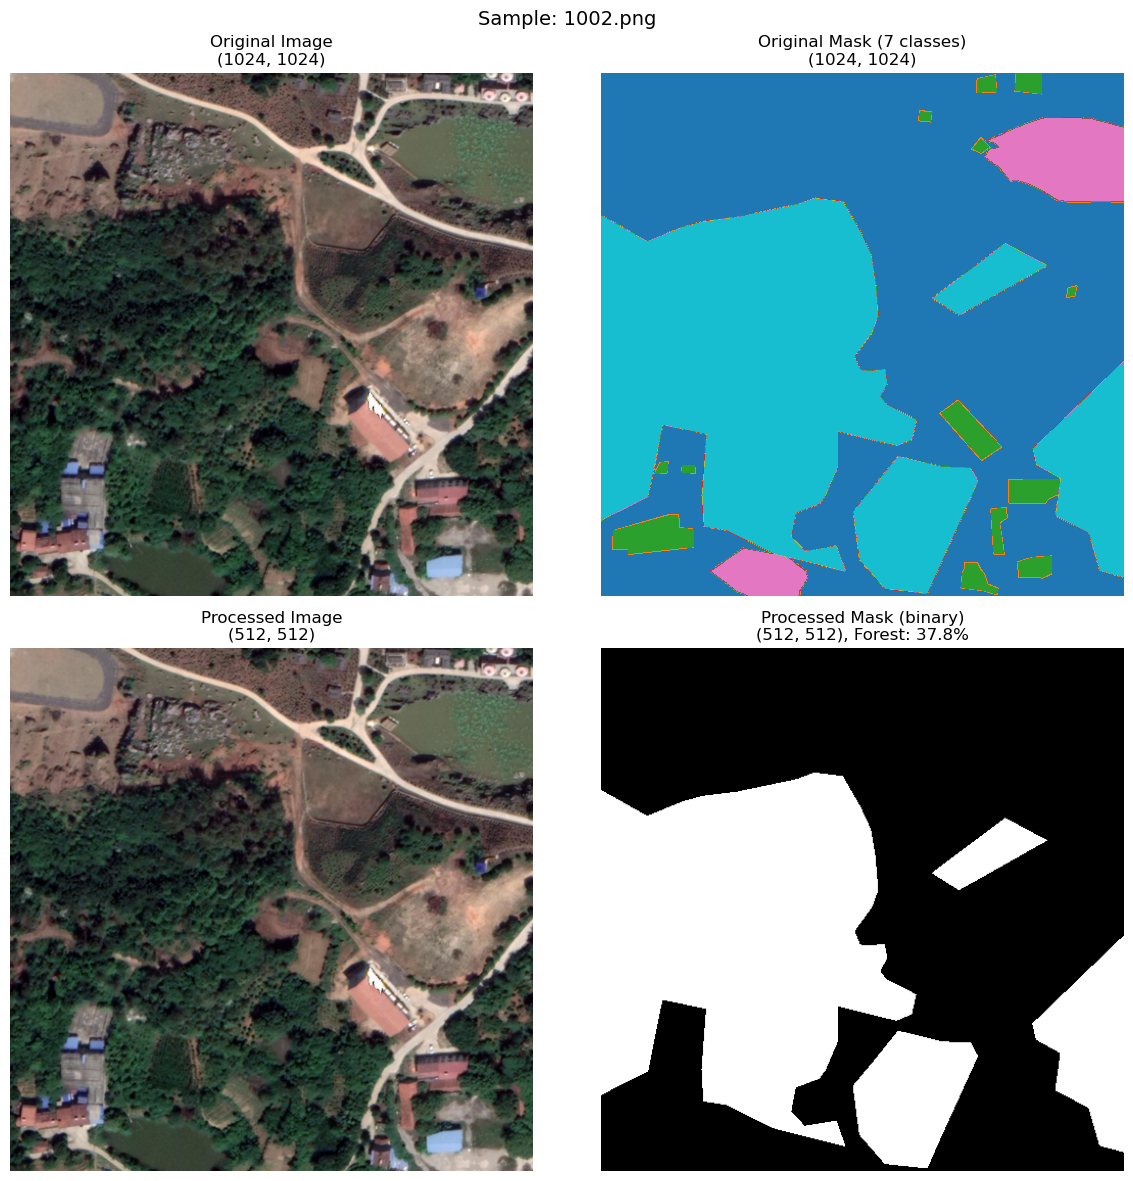

In [13]:
# Test processing on a sample image
sample_name = qualified_images[0][0]
sample_img_path = os.path.join(image_dir, sample_name)
sample_mask_path = os.path.join(mask_dir, sample_name)

# Process
orig_img = Image.open(sample_img_path)
orig_mask = Image.open(sample_mask_path)
proc_img = process_image(sample_img_path, TARGET_SIZE)
proc_mask = process_mask(sample_mask_path, TARGET_SIZE, FOREST_LABEL)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(orig_img)
axes[0, 0].set_title(f"Original Image\n{orig_img.size}")
axes[0, 0].axis('off')

axes[0, 1].imshow(orig_mask, cmap='tab10')
axes[0, 1].set_title(f"Original Mask (7 classes)\n{orig_mask.size}")
axes[0, 1].axis('off')

axes[1, 0].imshow(proc_img)
axes[1, 0].set_title(f"Processed Image\n{proc_img.size}")
axes[1, 0].axis('off')

axes[1, 1].imshow(proc_mask, cmap='gray')
forest_ratio = np.sum(np.array(proc_mask) == 255) / (TARGET_SIZE * TARGET_SIZE)
axes[1, 1].set_title(f"Processed Mask (binary)\n{proc_mask.size}, Forest: {forest_ratio*100:.1f}%")
axes[1, 1].axis('off')

plt.suptitle(f"Sample: {sample_name}", fontsize=14)
plt.tight_layout()
plt.show()

## Process and Save Dataset

In [15]:

for split_name in splits.keys():
    os.makedirs(os.path.join(OUTPUT_DIR, split_name, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split_name, "masks"), exist_ok=True)
    print(f"  Created: {OUTPUT_DIR}/{split_name}/")

  Created: F:\Train\Train\LoveDA_Processed/Training/
  Created: F:\Train\Train\LoveDA_Processed/Validation/
  Created: F:\Train\Train\LoveDA_Processed/Test/


In [16]:
total_processed = 0
for split_name, filenames in splits.items():
    print(f"Processing {split_name}...")
    
    for i, filename in enumerate(filenames):
        # Source paths
        src_image = os.path.join(image_dir, filename)
        src_mask = os.path.join(mask_dir, filename)
        
        # Check if source files exist
        if not os.path.exists(src_image) or not os.path.exists(src_mask):
            print(f"  Warning: File not found: {filename}")
            continue
        
        # Process
        processed_image = process_image(src_image, TARGET_SIZE)
        processed_mask = process_mask(src_mask, TARGET_SIZE, FOREST_LABEL)
        
        # Save
        dst_image = os.path.join(OUTPUT_DIR, split_name, "images", filename)
        dst_mask = os.path.join(OUTPUT_DIR, split_name, "masks", filename)
        
        processed_image.save(dst_image)
        processed_mask.save(dst_mask)
        
        total_processed += 1
        
        # Progress
        if (i + 1) % 20 == 0 or i == len(filenames) - 1:
            print(f"  Processed: {i + 1}/{len(filenames)}")
    
    print(f" {split_name}: {len(filenames)} images saved\n")

print(f"Total processed: {total_processed} images")

Processing Training...
  Processed: 20/70
  Processed: 40/70
  Processed: 60/70
  Processed: 70/70
 Training: 70 images saved

Processing Validation...
  Processed: 20/20
 Validation: 20 images saved

Processing Test...
  Processed: 10/10
 Test: 10 images saved

Total processed: 100 images


Visualization saved to: F:\Train\Train\LoveDA_Processed\visualization_samples.png


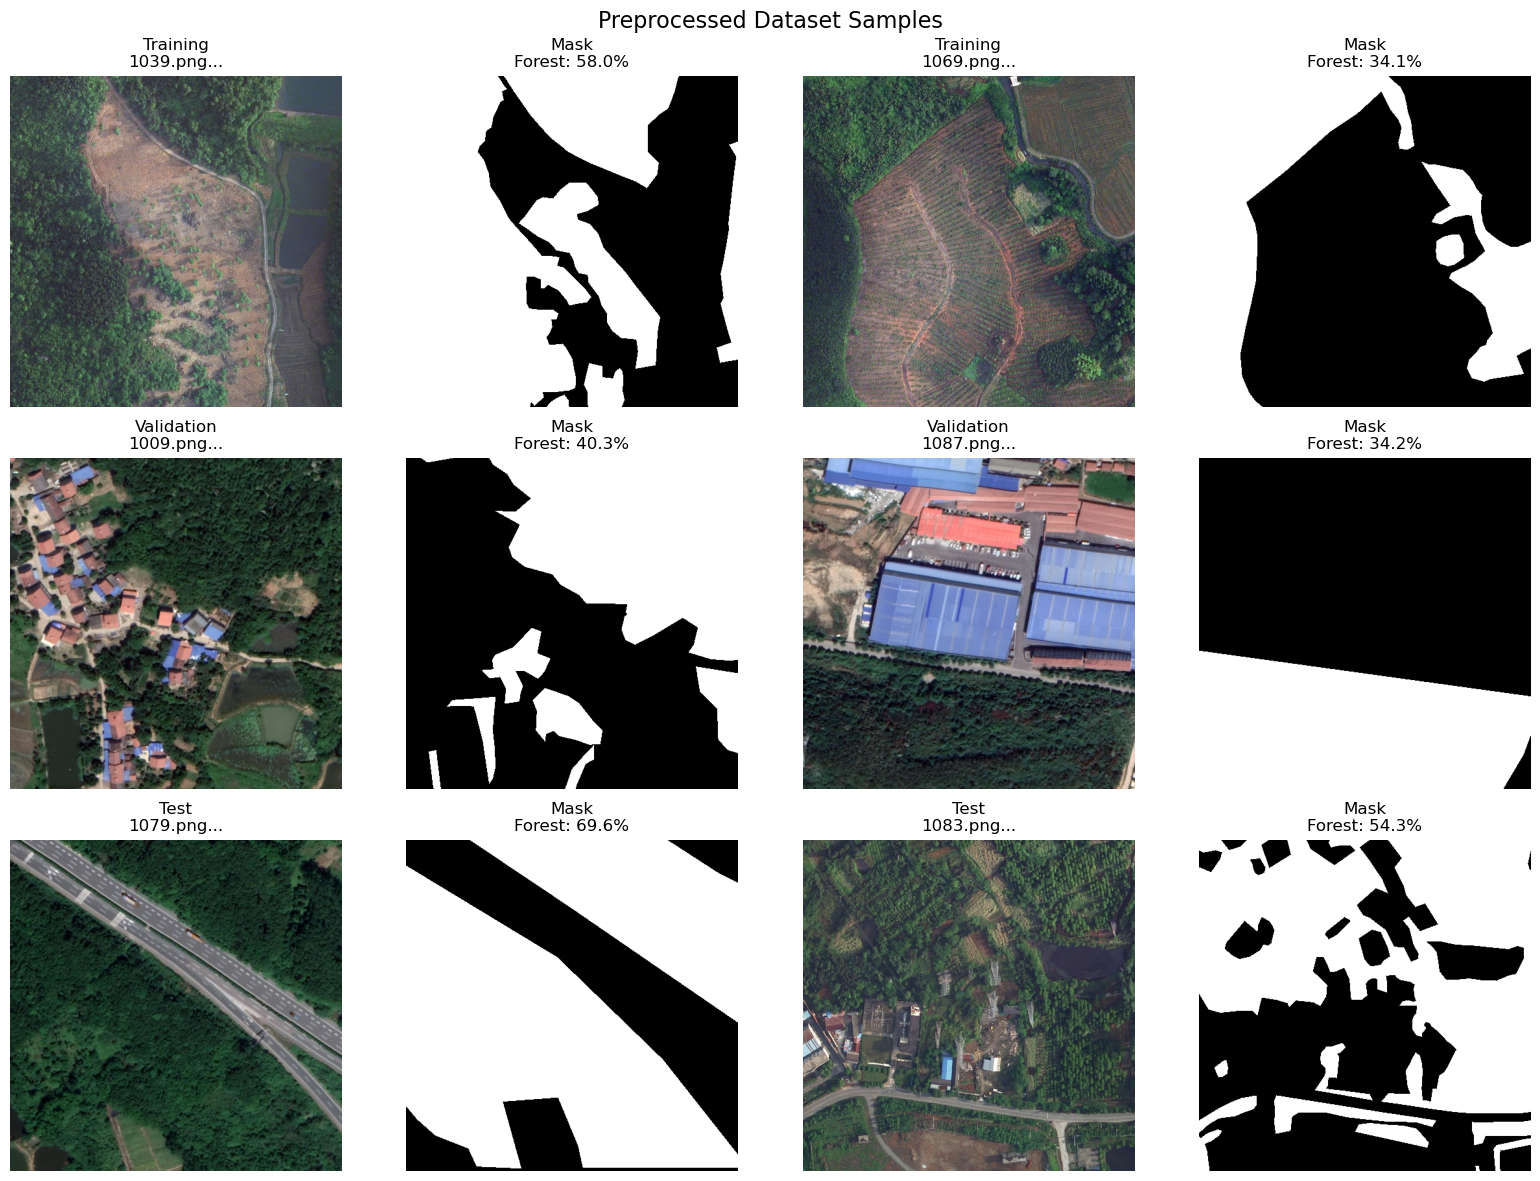

In [17]:
# Visualize samples from each split
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for row, split in enumerate(['Training', 'Validation', 'Test']):
    img_dir_out = os.path.join(OUTPUT_DIR, split, "images")
    mask_dir_out = os.path.join(OUTPUT_DIR, split, "masks")
    
    images = os.listdir(img_dir_out)[:2]  # Take 2 samples
    
    for col, img_name in enumerate(images):
        img = Image.open(os.path.join(img_dir_out, img_name))
        mask = Image.open(os.path.join(mask_dir_out, img_name))
        
        # Plot image
        axes[row, col * 2].imshow(img)
        axes[row, col * 2].set_title(f"{split}\n{img_name[:12]}...")
        axes[row, col * 2].axis('off')
        
        # Plot mask
        axes[row, col * 2 + 1].imshow(mask, cmap='gray')
        forest_ratio = np.sum(np.array(mask) == 255) / (TARGET_SIZE * TARGET_SIZE)
        axes[row, col * 2 + 1].set_title(f"Mask\nForest: {forest_ratio*100:.1f}%")
        axes[row, col * 2 + 1].axis('off')

plt.suptitle("Preprocessed Dataset Samples", fontsize=16)
plt.tight_layout()

# Save visualization
viz_path = os.path.join(OUTPUT_DIR, "visualization_samples.png")
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"Visualization saved to: {viz_path}")

plt.show()